In [46]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import models, transforms
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
DATA_INFO_PATH = os.path.join('..', 'data', 'corona_dataset', 'Chest_xray_Corona_Metadata.csv')
TRAIN_FOLDER = os.path.join('..', 'data', 'corona_dataset', 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')    
TEST_FOLDER = os.path.join('..', 'data', 'corona_dataset', 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')

In [14]:
data_info = pd.read_csv(DATA_INFO_PATH, index_col = 0)

In [15]:
data_info.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


## Implementing our Dataset to get the X-rays

IM-0464-0001.jpeg
person1424_virus_2437.jpeg
person162_virus_320.jpeg
NORMAL2-IM-1152-0001-0002.jpeg
person664_virus_1249.jpeg


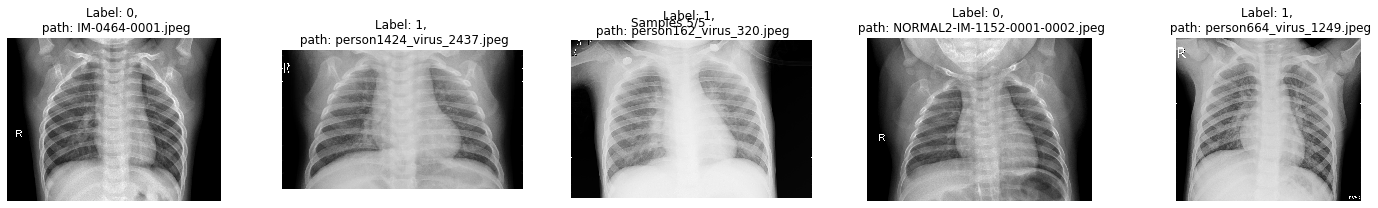

In [39]:
class Pneumonia_Dataset(Dataset):
    def __init__(self, csv_file, folder, transform = None):
        """
        csv_file (string) - scv file with metadata
        folder (string) - folder with images
        transform (callable, optional) - transform applied to the images, augmentation
        """
        self.csv_file = pd.read_csv(csv_file)
        self.folder = folder
        self.transform = transform
        
    def pil_loader(path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                return img.convert('RGB')
        
    def __len__(self):
        return len(os.listdir(self.folder))
    
    def __getitem__(self, index):
        image_name = os.listdir(self.folder)[index]
        image_path = os.path.join(self.folder, image_name)
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        y = 1 if self.csv_file.iloc[index]['Label'] == 'Pnemonia' else 0     ## target
        
        if self.transform:
            image = self.transform(image)
            
        return image, y, image_path
    
def visualize_samples(dataset, indices, title = None, count = 5):
    # visualize random 10 samples
    plt.figure(figsize=(count*5,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, path = dataset[index]
        path = os.path.split(path)[-1]
        print(path)
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.title(f"Label: {y}, \n path: {path}")
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')       

orig_dataset = Pneumonia_Dataset(DATA_INFO_PATH, TRAIN_FOLDER)
indices = np.random.choice(np.arange(len(orig_dataset)), 5, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

IM-0464-0001.jpeg
person1424_virus_2437.jpeg
person162_virus_320.jpeg
NORMAL2-IM-1152-0001-0002.jpeg
person664_virus_1249.jpeg


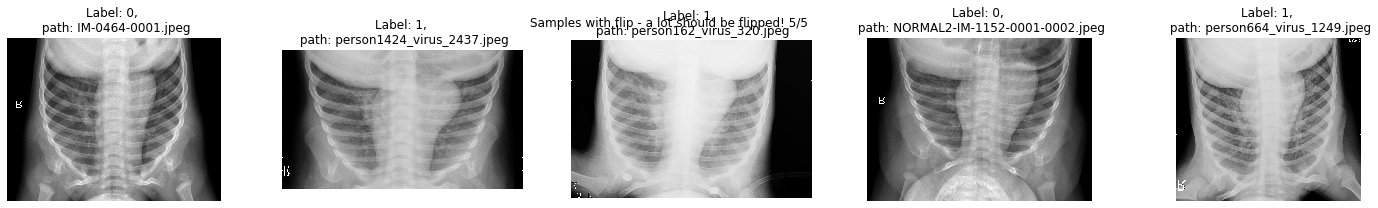

In [40]:
# Let's make sure transforms work!
dataset = Pneumonia_Dataset(DATA_INFO_PATH, TRAIN_FOLDER, transform=transforms.RandomVerticalFlip(0.9))
visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

## Creating our dataset for training

In [41]:
train_dataset = Pneumonia_Dataset(DATA_INFO_PATH, TRAIN_FOLDER, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = Pneumonia_Dataset(DATA_INFO_PATH, TEST_FOLDER, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [42]:
len(train_dataset), len(test_dataset)

(5309, 624)

## Go to training

In [48]:
batch_size = 64

data_size = len(dataset)
validation_fraction = 0.2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(11)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [50]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        if scheduler:
            scheduler.step()
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    right = 0
    total = 0
    for batch in loader:
        x, y, _ = batch
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        preds = model(x_gpu)
        preds = torch.argmax(preds, axis = 1)
        right += torch.sum(preds == y_gpu)
        total += y_gpu.shape[0]
    return float(right) / total

In [52]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained = False)
for param in model.parameters():        ## freezing
    param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)
model.to(device)
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

parameters = model.fc.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
# optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)
optimizer = optim.Adam(parameters, lr = 0.001)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

KeyboardInterrupt: 